In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('datasets_combine.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# LSTM Classifier Model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

In [ ]:
# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 2  # Adjust based on the number of target classes
num_epoch = 8

# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
VOCAB_SIZE = tokenizer.vocab_size

# Prepare the dataset and dataloader
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], df['label'], test_size=0.2)
train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_length=128)
val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, OUTPUT_DIM).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epoch):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader)}')
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 0.6831358548961108
Val Loss: 0.6800361913864059, Val Accuracy: 0.5305863708399366
Epoch: 2, Loss: 0.30171511807019197
Val Loss: 0.15110578283554676, Val Accuracy: 0.9591125198098257
Epoch: 3, Loss: 0.07929954587988838
Val Loss: 0.08923098091694592, Val Accuracy: 0.9683042789223455
Epoch: 4, Loss: 0.04712327097489534
Val Loss: 0.05429850823029575, Val Accuracy: 0.9797147385103011
Epoch: 5, Loss: 0.025017148520962536
Val Loss: 0.05580503113786549, Val Accuracy: 0.9806656101426308
Epoch: 6, Loss: 0.01426944336662352
Val Loss: 0.06435199354650603, Val Accuracy: 0.9793977812995246
Epoch: 7, Loss: 0.010667968044997653
Val Loss: 0.06868282765222977, Val Accuracy: 0.9828843106180666
Epoch: 8, Loss: 0.004453528414206296
Val Loss: 0.08939591866422261, Val Accuracy: 0.9803486529318542


In [ ]:
def predict(text, model=model, tokenizer=tokenizer, device=device):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten().to(device)
        outputs = model(input_ids)

        # normalize the scores to all positive and sum to 1
        outputs = torch.nn.functional.softmax(outputs, dim=0)

        return outputs

In [ ]:
df = pd.read_csv('datasets_combine.csv')
df, test_df = train_test_split(df, test_size=0.1, random_state=42)


In [ ]:
def prepare_data(df):
    t5_data = []
    for index, row in df.iterrows():
        sentence = row['sentence']
        # Define your prompt based on the style
        prompt = "Generate Shakespearean style:" if row['label'] == 1 else "Generate News style:"
        t5_data.append({
            'encoder_input': sentence,
            'decoder_input': prompt,
            'labels': sentence
        })
    return t5_data

t5_data = prepare_data(df)


In [ ]:
def mask_tokens(inputs, tokenizer, mlm_probability=0.15):
    labels = inputs.clone()
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # Only compute loss on masked tokens

    # Replace tokens with the mask token
    mask_token_id = tokenizer.convert_tokens_to_ids(tokenizer.additional_special_tokens[0])
    inputs[masked_indices] = mask_token_id

    return inputs, labels


In [ ]:
class T5StyleTransferDataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Encoding for T5 input (encoder)
        encoder_input = item['encoder_input']
        encoder_encoding = self.tokenizer(
            encoder_input,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Apply masking
        # input_ids, labels = mask_tokens(encoder_encoding.input_ids, self.tokenizer)

        # Encoding for T5 output (decoder prompt)
        decoder_input = item['decoder_input']
        decoder_encoding = self.tokenizer(
            decoder_input,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": input_ids.squeeze(),
            "attention_mask": encoder_encoding.attention_mask.squeeze(),
            "decoder_input_ids": decoder_encoding.input_ids.squeeze(),
            "labels": labels.squeeze()
        }



In [ ]:
!pip install sentencepiece

In [ ]:
# Load T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model_TST = T5ForConditionalGeneration.from_pretrained('t5-small')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_data, val_data = train_test_split(t5_data, test_size=0.2, random_state=42)
train_dataset = T5StyleTransferDataset(tokenizer, train_data)
val_dataset = T5StyleTransferDataset(tokenizer, val_data)


In [ ]:
# '''
# #training loop
# import tqdm
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4)

# model = T5ForConditionalGeneration.from_pretrained('t5-small')
# optimizer = AdamW(model.parameters(), lr=5e-5)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# num_epochs = 3
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
#         optimizer.zero_grad()

#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         decoder_input_ids = batch['decoder_input_ids'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask,
#                         decoder_input_ids=decoder_input_ids, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     avg_train_loss = total_loss / len(train_loader)
#     print(f"Average training loss: {avg_train_loss:.4f}")

#     # Validation Phase
#     model.eval()
#     total_eval_loss = 0
#     with torch.no_grad():
#         for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             decoder_input_ids = batch['decoder_input_ids'].to(device)
#             labels = batch['labels'].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask,
#                             decoder_input_ids=decoder_input_ids, labels=labels)
#             loss = outputs.loss
#             total_eval_loss += loss.item()

#     avg_val_loss = total_eval_loss / len(val_loader)
#     print(f"Average validation loss: {avg_val_loss:.4f}")
#     '''

In [ ]:
# from transformers import Trainer, TrainingArguments
# class StyleTransferTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs, labels=labels)
#         loss = outputs.loss
#         return (loss, outputs) if return_outputs else loss



In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

In [ ]:
# trainer for training
trainer = Trainer(
    model=model_TST,  # T5 model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,5.460300,5.337665
2,5.149500,4.896542
3,4.732600,4.786233


TrainOutput(global_step=8517, training_loss=5.824246015881266, metrics={'train_runtime': 3341.7377, 'train_samples_per_second': 10.195, 'train_steps_per_second': 2.549, 'total_flos': 4610824492548096.0, 'train_loss': 5.824246015881266, 'epoch': 3.0})

In [ ]:
!pip install transformers[torch]

In [ ]:
print(trainer.evaluate())

{'eval_loss': 4.789305210113525, 'eval_runtime': 91.3252, 'eval_samples_per_second': 31.098, 'eval_steps_per_second': 7.774, 'epoch': 3.0}


In [ ]:
def style_transfer(model, tokenizer, sentence, max_length=512, device='cpu'):
    # Set the model to evaluation mode
    model_TST.eval()
    print(sentence)
    pre_classification = predict(sentence).tolist()
    style = 'Shakespearean' if pre_classification[0] > pre_classification[1] else 'news'
    # Prepare the text input for the encoder
    encoder_inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    encoder_input_ids = encoder_inputs.input_ids.to(device)
    encoder_attention_mask = encoder_inputs.attention_mask.to(device)

    # Generate style-specific decoder input IDs
    style_prompt = f"Generate {style} style:"
    decoder_inputs = tokenizer(style_prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    decoder_input_ids = decoder_inputs.input_ids.to(device)

    # Use the model's generate function to perform generation
    with torch.no_grad():
        generated_ids = model_TST.generate(
            input_ids=encoder_input_ids,
            attention_mask=encoder_attention_mask,
            decoder_input_ids=decoder_input_ids,
            max_length=max_length,
            num_beams=1,  # You can change num_beams to a higher number for beam search
            early_stopping=True
        )

    # Decode the generated sequence to a string
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    generated_text = generated_text.split(':', 1)[1]
    print("generated_text:", generated_text)
    print("============")
    return generated_text

style_transfer(model_TST, tokenizer, "ckingham creaseth", device=device)

ckingham creaseth


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


generated_text: creaseth in the ckingham creaseth, a creaseth in the creaseth of the year.


'creaseth in the ckingham creaseth, a creaseth in the creaseth of the year.'

In [ ]:
def wrapper(sentence):
    return style_transfer(model_TST, tokenizer, sentence, device=device)
test_df['transfer_result'] = test_df['sentence'].apply(wrapper)

AUFIDIUS:I have not deserved it
generated_text: I have not deserved it, but it is not worth it, I have not deserved it, I have not deserved it, I have not deserved it, I have not deserved it, I have not deserved it, I have said it, and I have not deserved it, I have not deserved it, I have said it, and I have not deserved it, I have not deserved it, I have said it, and I have not deserved it, I have not deserved
LARTIUS:So, let the ports be guarded: keep your duties,As I have set them down
generated_text:  let the ports be guarded: keep your duties,I have set them down down,I have set them down down. So, let them be guarded: keep your duties,I have set them down down. Keep your duties,I have set them down down.I have set them down down.I have set them down down.I have set them down down.I have set them down down.I have set them down.I have set them down.I have set them down.I have set them
frustrated by heavy tax burdens and rising costs
generated_text:  high taxes and rising costs, th

In [ ]:
def label_generated_text_pred(sentence):
    label_prob = predict(sentence, model, tokenizer, device)
    if label_prob.tolist()[0] > 0.5:
        label = 0
    else:
        label = 1
    return label
test_df['label_generated_pred'] = test_df['transfer_result'].apply(label_generated_text_pred)

In [ ]:
def label_generated_text_real(original_label):
    if original_label == 0:
        label = 1
    else:
        label = 0
    return label
test_df['label_generated_real'] = test_df['label'].apply(label_generated_text_real)

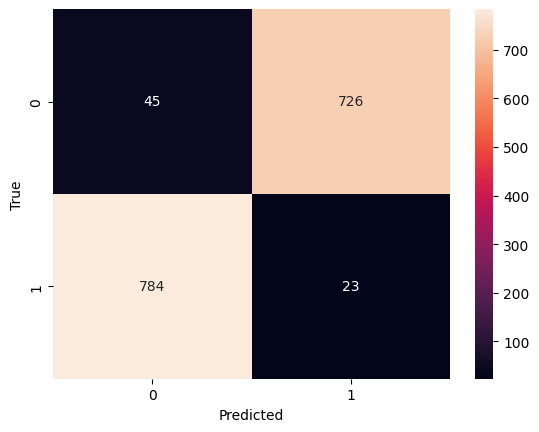

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_df['label_generated_real'], test_df['label_generated_pred'])
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

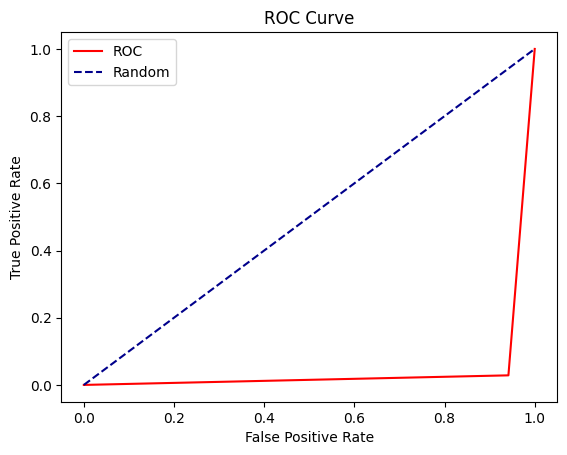

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
predict = test_df['label_generated_pred']
True_label = test_df['label_generated_real']
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
print(f'AUC: {auc}')

AUC: 0.04343318916677516


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(True_label, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.043092522179974654
